# House prices predictions using Random Forest regressors

In [19]:
# necessary for CI build ?
import subprocess
subprocess.call(["pip", "install", "seaborn", "--user"])

0

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from utils import train_test_split
from models import DecisionTree, RandomForest 
from metrics import RMSE, log_RMSE

RANDOM_SEED = 42

## Loading the data

In [2]:
train_data = pd.read_csv('data/housing_price_train.csv', index_col=0)
test_data = pd.read_csv('data/housing_price_test.csv', index_col=0)
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Preprocessing

Our first task is going to be the handling of missing values. To do so, we first assess the number and the percentage of missing values in the dataset. Note that each preprocessing step will be applied on both the training and the testing set, so that our final predictions are made on data having the same structure as what the model has been trained on.

In [3]:
n_missing = train_data.isnull().sum().sort_values(ascending=False)
p_missing = (n_missing/len(train_data))
missing_data = pd.concat([n_missing, p_missing], axis=1, keys=['# of missing values', '% of missing values'])
missing_data.head(20)

,# of missing values,% of missing values
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


First of all, we can notice that for all attributes $\in$ [PoolQC, MiscFeature, Alley, Fence, FireplaceQu, GarageType, GarageCond, GarageFinish, GarageQual, BsmtFinType2, BsmtExposure, BsmtQual, BsmtCond, BsmtFinType1, MasVnrType], ```NaN``` values are not missing but specific values described in the [housing description](data/housing_data_description.csv). As all these attributes are categorical, ```NaN``` values can be replaced by 'None' or any equivalent so that they belong to the same categoy.

In [4]:
attrs = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageCond', 'GarageFinish', 'GarageQual', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'MasVnrType']
train_data[attrs] = train_data[attrs].fillna('None')
test_data[attrs] = test_data[attrs].fillna('None')

Next, we have to deal with ```LotFrontage```. One could think that missing values of this attribute means al LotFrontage of zero, as in the previous case. Let's see the sale price distributions for known and unknown values of this attribute.

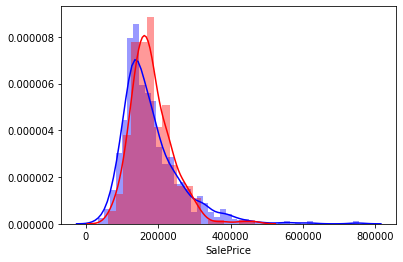

In [5]:
known_value = train_data[train_data['LotFrontage'].notnull()]
unknown_value = train_data[train_data['LotFrontage'].isnull()]

sns.distplot(known_value['SalePrice'], color='blue')
sns.distplot(unknown_value['SalePrice'], color='red')

As we can see, known and unknow values exhibit a similar distribution, so replacing missing values of ```LotFrontage``` with zeros would not represent accurately the underlying distribution of ```SalePrice```. Thus, we decide to replace missing values with the mean ```LotFrontage``` of of known values.

In [6]:
attr = 'LotFrontage'
train_data[attr] = train_data[attr].fillna(train_data[attr].mean())
test_data[attr] = test_data[attr].fillna(test_data[attr].mean())

Next, we deal with missing GarageYrBlt. This is a numerical attribute which doesn't make sense when there is no garage, so any replacement strategy would be biased. Furthermore, there are already numerical and categorical attributes describing the state of the garage : GarageType, GarageFinish, GarageCars, GarageArea, GarageQual and GarageCond. Our hypohesis is that the year of construction is a much less significant attribute than the area, the quality or the condition of the garage, which are all defined for all instances. We decide to drop this feature from the analysis.

In [7]:
attr = 'GarageYrBlt'
train_data.drop(attr, axis='columns', inplace=True)
test_data.drop(attr, axis='columns', inplace=True)

Finally, we deal with the 8 MasVnrArea and 1 Electrical missing values. Since there are so few of them and imputing their values would be purely hypothetical, we decide to drop these samples from the analysis.

In [8]:
attrs = ['MasVnrArea', 'Electrical']
train_data.dropna(axis='index', subset=attrs, inplace=True)

In [9]:
n_missing = train_data.isnull().sum().sort_values(ascending=False)
p_missing = (n_missing/len(train_data))
missing_data = pd.concat([n_missing, p_missing], axis=1, keys=['# of missing values', '% of missing values'])
missing_data.head(10)

,# of missing values,% of missing values
SalePrice,0,0.0
Foundation,0,0.0
RoofMatl,0,0.0
Exterior1st,0,0.0
Exterior2nd,0,0.0
MasVnrType,0,0.0
MasVnrArea,0,0.0
ExterQual,0,0.0
ExterCond,0,0.0
BsmtQual,0,0.0


Our training dataset is now clean. However, we can see that some null values remain in our test set. As they represent tiny fraction of the samples and mostly come from features for which we cannot derive default values , we consider these features as not decisive enough to perform further preprocessing.

In [10]:
n_missing = test_data.isnull().sum().sort_values(ascending=False)
p_missing = (n_missing/len(test_data))
missing_data = pd.concat([n_missing, p_missing], axis=1, keys=['# of missing values', '% of missing values'])
missing_data.head(20)

,# of missing values,% of missing values
MasVnrArea,15,0.009615
MSZoning,4,0.002564
Utilities,2,0.001282
BsmtHalfBath,2,0.001282
BsmtFullBath,2,0.001282
Functional,2,0.001282
Exterior1st,1,0.000641
KitchenQual,1,0.000641
Exterior2nd,1,0.000641
GarageArea,1,0.000641


In [11]:
train_labels = train_data.pop('SalePrice')
x_train, y_train, x_val, y_val = train_test_split(train_data, train_labels)

## Evaluation

In [12]:
model = RandomForest(n_trees=32, max_depth=10)
model.fit(x_train.values, y_train.values)
y_pred = model.predict(x_val.values)

In [13]:
baseline_error = RMSE(np.repeat(y_train.values.mean(), len(y_val)), y_val.values)
error = RMSE(y_pred, y_val.values)
log_error = log_RMSE(y_pred, y_val.values)
print(f'RMSE : {error:.1f} - log-RMSE : {log_error:.5f} - {error/baseline_error:.1%} of baseline error')

RMSE : 31408.6 - log-RMSE : 0.13325 - 37.7% of baseline error


## Prediction

In [14]:
model = RandomForest(n_trees=32, max_depth=10)
model.fit(train_data.values, train_labels.values)
y_pred = model.predict(test_data.values)

## Submission

In [15]:
def submit(idx, predictions):
    submission = pd.DataFrame()
    submission['Id'] = idx
    submission['SalePrice'] = predictions
    submission.to_csv('submission.csv', index=False)

In [16]:
submit(test_data.index, y_pred)